In [31]:
import torch
import torchinfo
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import confusion_matrix

import dsutils 
import metrics


import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [9]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
resnet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)


utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet152.eval().to(device)
resnet101.eval().to(device)
resnet50.eval().to(device)
resnet34.eval().to(device)
resnet18.eval().to(device)
alexnet.eval().to(device)

Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# filenames for imagenet sample images

# You must replace this with a path to the directory that contains the images you want to use.  We are just using a set of imagenet sample images from https://github.com/EliSchwartz/imagenet-sample-images

fnames = os.listdir('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test')

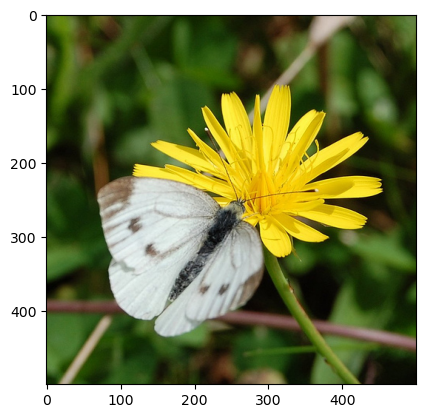

In [11]:
# Show an image

trial_image = fnames[610]
input_image = Image.open('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test/'+ trial_image)

plt.imshow(input_image)

In [12]:
# Define preprocessing 

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
# preprocess one image
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model


In [18]:
# Test a model (run forward pass with test image)

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(input_batch), dim=1)

results = utils.pick_n_best(predictions=output, n=3)

sample 0: [('cabbage butterfly', '85.9%'), ('sulphur butterfly, sulfur butterfly', '0.3%'), ('ringlet, ringlet butterfly', '0.2%')]


In [20]:
# Split the network in two halfs and extract the representations at a specified layer

# AlexNet

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

module1 = list(alexnet.children())[:1]
module2 = list(alexnet.children())[1:2]

anet_1st = nn.Sequential(*[*module1, *module2, dsutils.Flatten()])

anet_2nd = nn.Sequential(*[list(alexnet.children())[-1], dsutils.SoftMaxModule() ])

with torch.no_grad():
    for inputs, _ in trainloader:
        x1 = anet_1st(inputs)
        x2 = anet_2nd(x1) 
        # output = torch.nn.functional.softmax(alexnet(inputs), dim=1) # check classifications



In [21]:
results = utils.pick_n_best(predictions=x2, n=3)

sample 0: [('tench, Tinca tinca', '97.6%'), ('banded gecko', '1.5%'), ('sturgeon', '0.4%')]
sample 1: [('goldfish, Carassius auratus', '100.0%'), ('tench, Tinca tinca', '0.0%'), ('rock beauty, Holocanthus tricolor', '0.0%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '86.8%'), ('tiger shark, Galeocerdo cuvieri', '3.7%'), ('coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', '2.3%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '99.5%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.3%'), ('hammerhead, hammerhead shark', '0.2%')]
sample 4: [('swimming trunks, bathing trunks', '91.7%'), ('sarong', '4.4%'), ('bikini, two-piece', '0.8%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '98.3%'), ('stingray', '1.6%'), ('muzzle', '0.0%')]
sample 6: [('stingray', '60.8%'), ('electric ray, crampfish, numbfish, torpedo', '36.8%'), ('sea slug, nudibranch', '0.9%

In [24]:
# Split the network in two halfs and extract the representations at a specified layer

# ResNet 50

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

module1 = list(resnet50.children())[:6]
module2 = list(resnet50.children())[6:]

rnet50_1st = nn.Sequential(*[*module1, dsutils.Flatten()])
rnet50_2nd = nn.Sequential(*[*module2, dsutils.SoftMaxModule() ])

with torch.no_grad():
    for inputs, _ in trainloader:
        y1 = rnet50_1st(inputs)
        y2 = rnet50_2nd(y1) 
        output = torch.nn.functional.softmax(resnet50(inputs), dim=1) # check classifications


In [27]:
results = utils.pick_n_best(predictions=y2, n=3)

sample 0: [('tench, Tinca tinca', '78.6%'), ('goldfish, Carassius auratus', '1.1%'), ('coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', '0.7%')]
sample 1: [('goldfish, Carassius auratus', '82.1%'), ('tench, Tinca tinca', '0.6%'), ('rock beauty, Holocanthus tricolor', '0.2%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '79.1%'), ('tiger shark, Galeocerdo cuvieri', '11.6%'), ('hammerhead, hammerhead shark', '0.2%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '78.3%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.6%'), ('hammerhead, hammerhead shark', '0.1%')]
sample 4: [('hammerhead, hammerhead shark', '70.8%'), ('swimming trunks, bathing trunks', '10.4%'), ('eel', '2.1%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '50.6%'), ('stingray', '12.0%'), ('window screen', '0.3%')]
sample 6: [('stingray', '52.1%'), ('electric ray, crampfish, numbfish

In [30]:
x1.shape

torch.Size([1029, 9216])

In [36]:
ckascore = metrics.LinearCKA(center_columns=True)

AttributeError: module 'metrics' has no attribute 'LinearCKA'